# DNN

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils import data
from torchvision import datasets, transforms, utils

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
tr_ds = datasets.FashionMNIST(root='../data/',
                              train=True,
                              download=True,
                              transform=transform)

In [4]:
tt_ds = datasets.FashionMNIST(root='../data/',
                              train=False,
                              download=True,
                              transform=transform)

In [5]:
tr_ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
tr_ds_loader = data.DataLoader(dataset=tr_ds, batch_size=16)
tt_ds_loader = data.DataLoader(dataset=tt_ds, batch_size=16)

In [7]:
ds = iter(tr_ds_loader)
img, label = next(ds)

In [8]:
img.shape, label.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [9]:
label

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])

In [10]:
정답 = {
    0: '티셔츠/탑 (T-shirt/top)',    
    1: '트라우저 (Trouser)',
    2: '풀오버 (Pullover)',
    3: '드레스 (Dress)',
    4: '코트 (Coat)',
    5: '샌들 (Sandal)',
    6: '셔츠 (Shirt)',
    7: '스니커즈 (Sneaker)',
    8: '가방 (Bag)',
    9: '앵클 부츠 (Ankle boot)',
}

In [11]:
idx = label[0].item() # 텐서를 값으로 변경

In [12]:
정답[idx]

'앵클 부츠 (Ankle boot)'

In [13]:
img[0].squeeze().shape

torch.Size([28, 28])

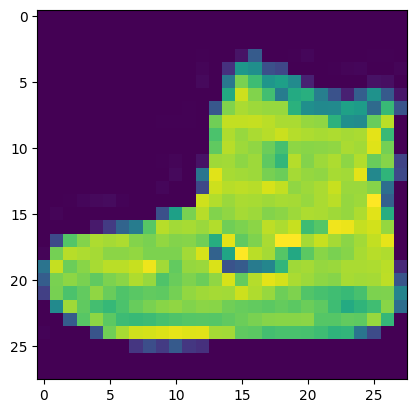

In [14]:
plt.imshow(img[0].squeeze())

In [15]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [16]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
DEVICE

device(type='cpu')

In [24]:
# 작업 준비
BATCH_SIZE = 32

In [ ]:
# 1. 데이터 준비 / 2. 데이터 전처리
transfrom = transforms.Compose([
    transforms.ToTensor()
]) # 데이터 사용 방식 내용 결정
tr_ds = datasets.FashionMNIST(
    root='../data/',
    train=True,
    download=False,
    transform=transform
)
tt_ds = datasets.FashionMNIST(
    root='../data/',
    train=False,
    download=False,
    transform=transform
)
tr_ds_loader = torch.utils.data.DataLoader(
    dataset=tr_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)
tt_ds_loader = torch.utils.data.DataLoader(
    dataset=tt_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [26]:
sizes = []
for x, y in tr_ds_loader:
    sizes.append(x.size(0))

print(set(sizes))

{32}


In [27]:
for i in tr_ds_loader:
    print('x:', i[0].shape)
    print('y:', i[1].shape)
    break

x: torch.Size([32, 1, 28, 28])
y: torch.Size([32])


In [28]:
for i in tt_ds_loader:
    print('x:', i[0].shape)
    print('y:', i[1].shape)
    break

x: torch.Size([32, 1, 28, 28])
y: torch.Size([32])


In [33]:
# 3. 모델 설계
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) # layer는 층 사이의 연결선
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

In [30]:
DEVICE

device(type='cpu')

In [34]:
model = Model().to(DEVICE) # 파라미터를 내가 원하는 곳 cpu나 gpu로 보낼 수 있음. 파이토치는 cpu냐 gpu냐 공간에 따라 연산 규칙이 다름.
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [45]:
(torch.argmax(model(i[0]), dim=1) == i[1]).sum()

tensor(4)

In [78]:
# 학습 함수 설계
def train(model, tr_ds_loader, optimizer):
    model.train()
    total_loss = 0.
    correct = 0
    total = 0
    for data, target in tr_ds_loader: # data와 target은 현재 메모리에 있는 상태
        # DataLoader는 항상 (data, target) 형태의 튜플을 반환
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(data) # Tensor 계속 쌓이면 메모리 잡아먹음 .item() 해줄 것
        pred = torch.argmax(output, dim=1)
        correct += (pred == target).sum().item()
        total += len(data)

        train_loss = total_loss / total
        train_accuracy = correct / total * 100

        tr_ds_loader.set_postfix({
            "train_loss": f"{train_loss:.4f}",
            "train_accuracy": f"{train_accuracy:.2f}%"
        })

    return train_loss, train_accuracy

In [48]:
def evaluate(model, tt_ds_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tt_ds_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1] # 인스턴스 집합으로 출력된 값을 하나로 출력
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(tt_ds_loader.dataset)
    test_accuracy = correct / len(tt_ds_loader.dataset) * 100.
    return test_loss, test_accuracy

In [80]:
from tqdm import tqdm

EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_bar = tqdm(
        tr_ds_loader,
        desc=f"Epoch {epoch}/{EPOCHS}",
        leave=True
    )

    train_loss, train_accuracy = train(
        model,
        train_bar,
        optimizer
    )

    test_loss, test_accuracy = evaluate(model, tt_ds_loader)

    print(f"[Epoch: {epoch}] "
          f"train_loss: {train_loss:.4f}, "
          f"train_acc: {train_accuracy:.2f} | "
          f"test_loss: {test_loss:.4f}, "
          f"test_acc: {test_accuracy:.2f} | "
          f"time: {train_bar.format_dict['elapsed']:.2f}")

Epoch 1/3: 100%|██████████| 1875/1875 [00:12<00:00, 150.15it/s, train_loss=0.1169, train_accuracy=95.88%]


[Epoch: 1] train_loss: 0.1169, train_acc: 95.88 | test_loss: 0.3823, test_acc: 88.59 | time: 13.65


Epoch 2/3: 100%|██████████| 1875/1875 [00:12<00:00, 147.26it/s, train_loss=0.1147, train_accuracy=95.95%]


[Epoch: 2] train_loss: 0.1147, train_acc: 95.95 | test_loss: 0.3759, test_acc: 88.36 | time: 13.95


Epoch 3/3: 100%|██████████| 1875/1875 [00:11<00:00, 157.81it/s, train_loss=0.1133, train_accuracy=95.95%]


[Epoch: 3] train_loss: 0.1133, train_acc: 95.95 | test_loss: 0.3786, test_acc: 88.20 | time: 13.03


In [81]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_bar = tqdm(
        tr_ds_loader,
        desc=f"Epoch {epoch}/{EPOCHS}",
        leave=True
    )

    train_loss, train_accuracy = train(
        model,
        train_bar,
        optimizer
    )

    test_loss, test_accuracy = evaluate(model, tt_ds_loader)
    
    tqdm.write(
        f"[Epoch: {epoch}] "
        f"train_loss: {train_loss:.4f}, "
        f"train_acc: {train_accuracy:.2f} | "
        f"test_loss: {test_loss:.4f}, "
        f"test_acc: {test_accuracy:.2f} | "
        f"time: {train_bar.format_dict['elapsed']:.2f}"
    )

Epoch 1/3: 100%|██████████| 1875/1875 [00:11<00:00, 163.21it/s, train_loss=0.1125, train_accuracy=96.00%]


[Epoch: 1] train_loss: 0.1125, train_acc: 96.00 | test_loss: 0.3727, test_acc: 88.64 | time: 12.58


Epoch 2/3: 100%|██████████| 1875/1875 [00:12<00:00, 149.96it/s, train_loss=0.1096, train_accuracy=96.10%]


[Epoch: 2] train_loss: 0.1096, train_acc: 96.10 | test_loss: 0.3622, test_acc: 89.00 | time: 13.65


Epoch 3/3: 100%|██████████| 1875/1875 [00:12<00:00, 146.81it/s, train_loss=0.1088, train_accuracy=96.15%]


[Epoch: 3] train_loss: 0.1088, train_acc: 96.15 | test_loss: 0.3752, test_acc: 89.25 | time: 13.97


In [82]:
tt_data, tt_target = next(iter(tt_ds_loader))
tt_data.shape, tt_target.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

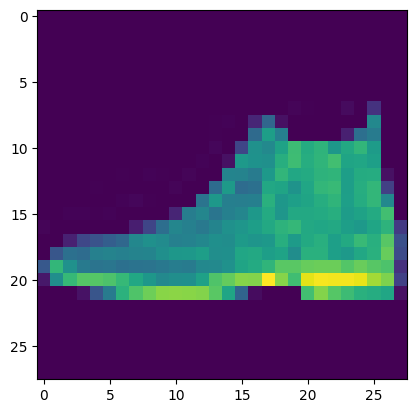

In [84]:
plt.imshow(tt_data[0].squeeze())

In [101]:
def decoding(input):
    return [정답[i] for i in model(input).argmax(1).tolist()]

In [104]:
decoding(tt_data)

['앵클 부츠 (Ankle boot)',
 '풀오버 (Pullover)',
 '트라우저 (Trouser)',
 '트라우저 (Trouser)',
 '셔츠 (Shirt)',
 '트라우저 (Trouser)',
 '코트 (Coat)',
 '셔츠 (Shirt)',
 '샌들 (Sandal)',
 '스니커즈 (Sneaker)',
 '코트 (Coat)',
 '샌들 (Sandal)',
 '샌들 (Sandal)',
 '드레스 (Dress)',
 '코트 (Coat)',
 '트라우저 (Trouser)',
 '풀오버 (Pullover)',
 '풀오버 (Pullover)',
 '가방 (Bag)',
 '티셔츠/탑 (T-shirt/top)',
 '풀오버 (Pullover)',
 '샌들 (Sandal)',
 '스니커즈 (Sneaker)',
 '샌들 (Sandal)',
 '트라우저 (Trouser)',
 '코트 (Coat)',
 '셔츠 (Shirt)',
 '티셔츠/탑 (T-shirt/top)',
 '앵클 부츠 (Ankle boot)',
 '드레스 (Dress)',
 '가방 (Bag)',
 '가방 (Bag)']

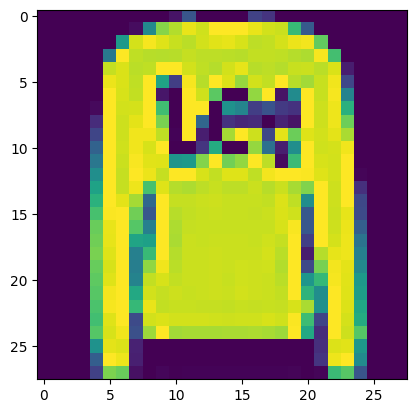

In [106]:
plt.imshow(tt_data[1].squeeze())